# Explore Zenodo community

In [1]:
from zenodoExplorer.zenexp import ze

recIDs = [10835267, 10712131, 10890165]
with open("api.key", "r") as keyFile:
    ACCESS_TOKEN = keyFile.readline().rstrip()

z = ze(ACCESS_TOKEN, recIDs, cache='~/.zenodo_cache/')
z.read_zdb()
z.zdb.del_dat_tree('td1@10835267')
z.zdb.del_dat_tree('td1@10890165')
z.zdb.del_dat_tree('ml3@10835267')
z.zdb.del_dat_tree('md2@10835267')
z.zdb.del_dat_tree('md1@10712131')
z.zdb.plot()

In [2]:
z.zdb.to_pd('AtomicConfigs')

,desc
tag,
ac1@10835267,"EC:EMC liquid PBC, isolated mols, volume scans..."
ac1@10712131,"EC:VC:PC:EMC:DMC:DEC mol clusters, 25% of all ..."
ac2@10712131,"EC:VC:PC:EMC:DMC:DEC mol clusters, 7% of all n..."


In [3]:
z.zdb.to_pd('TrainData')

,at_conf,ab_init_code,ab_init_theo
tag,,,
td2@10835267,ac1@10835267,CP2K,PBE-D3
td1@10712131,ac1@10835267,VASP,B97-D3BJ
td2@10712131,ac1@10712131,PSI4,B97-D3BJ
td3@10712131,ac1@10712131,PSI4,wB97X-D3BJ
td4@10712131,ac2@10712131,PSI4,wB97X-D3BJ


In [4]:
z.zdb.to_pd('MLIPs')

,tr_data,ml_code,ml_settings,fit_prop
tag,,,,
ml4@10835267,td2@10835267,GAP,"DTS, Rcut 3/6","energy, forces, virial"
ml1@10712131,td1@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"
ml2@10712131,td2@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"
ml3@10712131,td3@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"
ml4@10712131,td4@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"
ml5@10712131,td2@10835267,MACE,"Layers 2, Rcut 6+6","energy, forces, virial"


In [5]:
z.zdb.to_pd('MDSims')

,pes_model,md_code,md_system,md_no_at,md_ensmb,md_step,md_len,md_temp,md_pres
tag,,,,,,,,,
md1@10835267,ml4@10835267,LAMMPS,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,1.0 ns,300 K,1 atm
md2@10712131,ml3@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,0.5 fs,0.5-1.0 ns,"298, 298, 298, 313 K",1 atm
md3@10712131,ml4@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.5 ns,"298, 298, 298, 313 K",1 atm
md4@10712131,ml1@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.8-1.0 ns,"298, 298, 298, 313 K",1 atm
md5@10712131,ml2@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.8-1.0 ns,"298, 298, 298, 313 K",1 atm
md6@10712131,ml5@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,1.0 ns,"298, 298, 298, 298 K",1 atm


# Get MD trajectories

In [6]:
import os
from aseMolec import pltProps as pp

def get_all_thermo(tag):
    thermo = {}
    flist = z.read_dat_files(tag, ext='.thermo')
    for f in flist:
        aux = os.path.basename(f)
        key = os.path.splitext(aux)[0]
        thermo.update({key: pp.loadtxttag(f)})
    return thermo

tags = ['md1@10835267', 'md6@10712131', 'md2@10712131', 'md4@10712131', 'md5@10712131']
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(tag)

# from old paper, will be replaced with MACE MD
pp.rename_key(thermo['md1@10835267'], 'TimeStep', 'Time')
pp.rename_key(thermo['md1@10835267'], 'v_mdensity', 'Density')
pp.rename_key(thermo['md1@10835267'], 'c_compMSD[4]', 'MSD')
pp.convert_units(thermo['md1@10835267'], 'Density', 'g/cm$^3$', 1.0)
pp.convert_units(thermo['md1@10835267'], 'MSD', 'A$^2$', 1.0)
thermo['md1@10835267'] = {
    k_new : thermo['md1@10835267'][k_old]
    for k_old, k_new in zip(['67EMC_300K', '25EC_50EMC_300K', '57EC_29EMC_300K', '100EC_300K'],
                            ['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])
}

for tag in thermo:
    pp.convert_units(thermo[tag], 'Time', 'ps', 0.001)

def_cols = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
def_lege = ['EMC', 'EC:EMC (3:7)', 'EC:EMC (7:3)', 'EC']
def_conc = [0/67, 25/75, 57/(29+57), 100/100]
def_meth = ['GAP_IBM23_PBE', 'MACE_IBM23_PBE', 'MACE_SD22NQ_wB97X', 'MACE_IBM23_B97', 'MACE_SD22NQ_B97']

# Compare MD trajectories

## compute average densities and diffusivities

In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from aseMolec import pltProps as pp
import ase.units
densfact = (ase.units.m/1.0e2)**3/ase.units.mol

def compute(thermo_md, t0=0):
    # t0: in picoseconds, how much of the MD traj to ignore from the start
    idx = np.where(thermo_md['Time']['data']>t0)[0][0]
    t = thermo_md['Time']['data'][idx:]
    dens = thermo_md['Density']['data'][idx:]
    msd = thermo_md['MSD']['data'][idx:]

    dens_avg = dens.mean() #g/cm^3
    D, offs = np.polyfit(t, msd, deg=1)
    D /= 6 #final unit: A^2/ps
    D *= 100 #final unit: 10^-10 m^2/s or 10^-6 cm^2/s
    return dens_avg, D, offs

dens_col = []
diff_col = []
offs_col = []
for tag in tags:
    dens = dict()
    diff = dict()
    offs = dict()
    for k in thermo[tag]:
        rho, D, o = compute(thermo[tag][k], t0=100)
        dens[k] = rho
        diff[k] = D
        offs[k] = o
    dens_col.append(dens)
    diff_col.append(diff)
    offs_col.append(offs)

dens_df_comp = pd.DataFrame(dens_col).round(2)
dens_df_comp.index = def_meth
dens_df_comp.columns = def_lege

diff_df_comp = pd.DataFrame(diff_col).round(2)
diff_df_comp.index = def_meth
diff_df_comp.columns = def_lege

## plot densities and diffusivities

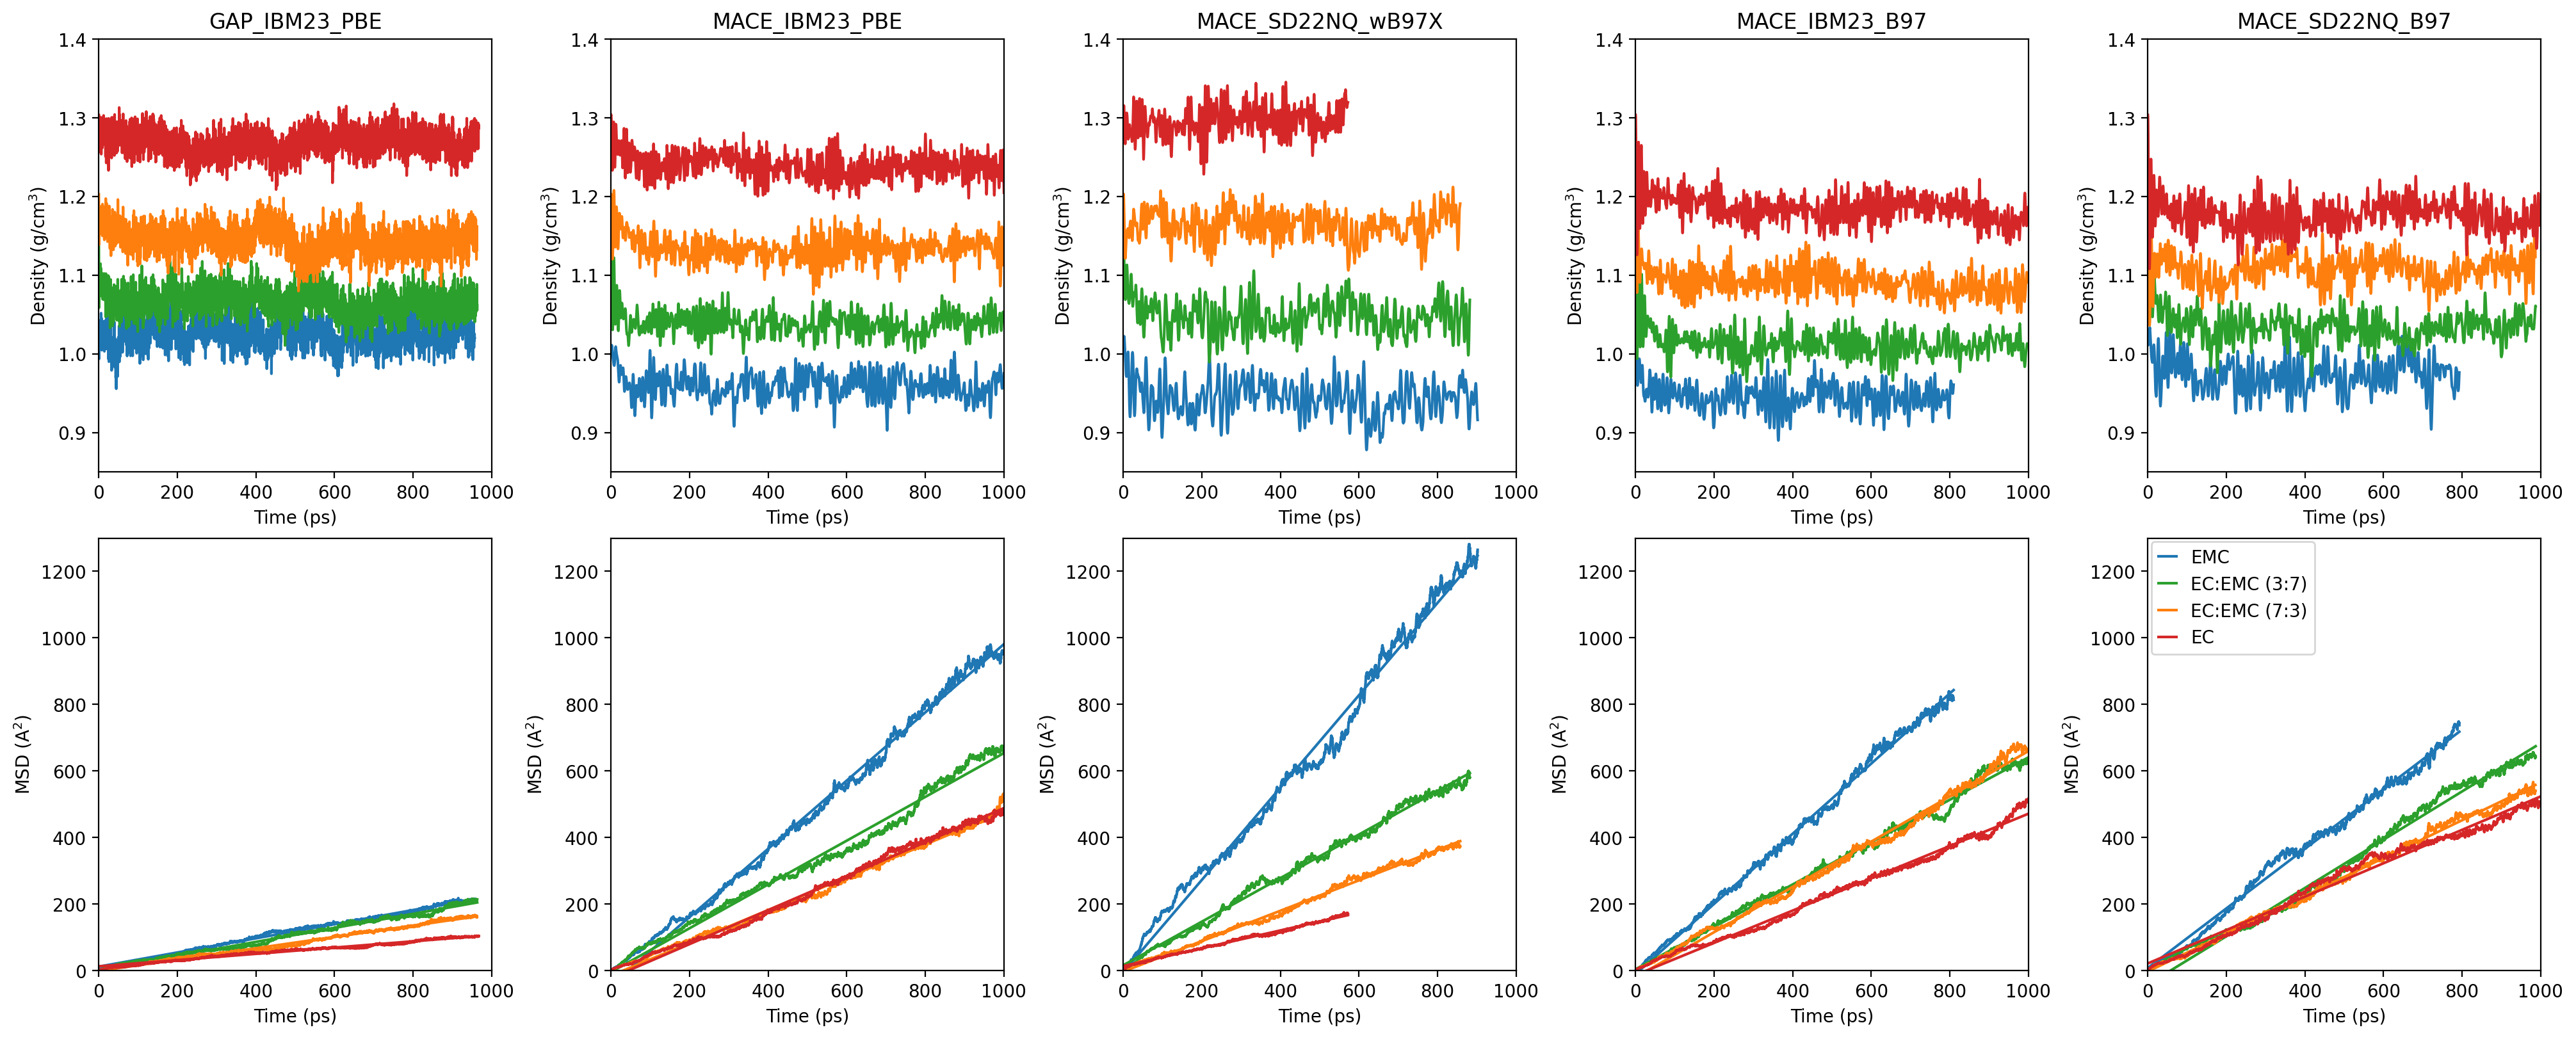

In [8]:
fig, axes = plt.subplot_mosaic(mosaic='ABCDE;FGHIJ', figsize=(20,8), dpi=200, layout='constrained')

# Density
for tag, panel, title in zip(tags, ['A', 'B', 'C', 'D', 'E'], def_meth): #loop over methods
    plt.sca(axes[panel])
    for i, k in enumerate(thermo[tag]): #loop over compositions
        pp.simpleplot(thermo[tag][k], 'Time', 'Density', byKey=True, color=def_cols[i])
    plt.xlim([0,1000])
    plt.ylim([0.85,1.4])
    plt.title(title)

# Diffusivity
for j, (tag, panel) in enumerate(zip(tags, ['F', 'G', 'H', 'I', 'J'])): #loop over methods
    plt.sca(axes[panel])
    for i, k in enumerate(thermo[tag]): #loop over compositions
        pp.simpleplot(thermo[tag][k], 'Time', 'MSD', byKey=True, color=def_cols[i])
        plt.plot(thermo[tag][k]['Time']['data'], thermo[tag][k]['Time']['data']*diff_col[j][k]/100*6+offs_col[j][k], color=def_cols[i], label='_nolegend_')
    plt.xlim([0,1000])
    plt.ylim([0,1300])

plt.legend(def_lege, handlelength=1, loc='upper left', borderaxespad=0.2)


## Add Schrodinger data and experiment: Holly, 

In [71]:
from joblib import load

exp_dens = load('.cache/exp/dens.joblib');
exp_dens_vals = exp_dens.predict(pd.DataFrame({'xEC': [0/67, 25/75, 57/(29+57), 100/100], 'Temp': [25, 25, 25, 40]}))

dens_schrod = pd.DataFrame({'EMC': 0.99, 'EC:EMC (3:7)': np.NaN, 'EC:EMC (7:3)': np.NaN, 'EC': 1.35}, index=['Original Schrod'])
dens_experiment = pd.DataFrame({'EMC': 1.01, 'EC:EMC (3:7)': np.NaN, 'EC:EMC (7:3)': np.NaN, 'EC': 1.32}, index=['Experiment'])
dens_experiment_GPR = pd.DataFrame({'EMC': exp_dens_vals[0], 'EC:EMC (3:7)': exp_dens_vals[1], 'EC:EMC (7:3)': exp_dens_vals[2], 'EC': exp_dens_vals[3]}, index=['Experiment (GPR)'])
dens_df = pd.concat([dens_df_comp.iloc[:2], dens_schrod, dens_experiment, dens_experiment_GPR, dens_df_comp.iloc[2:]])
dens_df.round(2)

,EMC,EC:EMC (3:7),EC:EMC (7:3),EC
GAP_IBM23_PBE,1.03,1.07,1.14,1.27
MACE_IBM23_PBE,0.96,1.04,1.13,1.24
Original Schrod,0.99,NaN,NaN,1.35
Experiment,1.01,NaN,NaN,1.32
Experiment (GPR),1.01,1.09,1.20,1.32
MACE_SD22NQ_wB97X,0.94,1.05,1.16,1.30
MACE_IBM23_B97,0.94,1.01,1.09,1.18
MACE_SD22NQ_B97,0.97,1.03,1.11,1.18


# Compute diffusion correction

Our simulations have the same number of molecules as Schrodinger 100 EC and 67 EMC, so we can compute total masses from our starting configs:

In [10]:
from ase.io import read

EC = read(z.read_dat_files('md2@10712131', ext='.xyz')[-1], '0')
EMC = read(z.read_dat_files('md2@10712131', ext='.xyz')[0], '0')

print(EC.get_masses().sum())
print(EMC.get_masses().sum())

8806.199999999999
6975.034999999999


For the diffusion data, we first need to compute the correction coefficients used by [Schrodinger SI, equ 5](https://pubs.acs.org/doi/suppl/10.1021/acs.jpcb.2c03746/suppl_file/jp2c03746_si_001.pdf) and [Bamboo, equ 61](https://arxiv.org/pdf/2404.07181), quoting [standard practice, equ 3](https://livecomsjournal.org/index.php/livecoms/article/view/v1i1e6324/937).
$$
D(\infty)=D(L)+\frac{2.837298\times k_BT}{6\pi \eta L}
$$
Box sizes are computed from number of molecules (table S1) and densities (table S2) from Schrodinger, temperatures are taken from table S1 and viscosity from table S3:

In [11]:
import ase.units

M_EC = EC.get_masses().sum()
M_EMC = EMC.get_masses().sum()

m_EC = M_EC/100
m_EMC = M_EMC/67

V_EC = M_EC/1.35*densfact
V_EMC = M_EMC/0.99*densfact

L_EC = V_EC**(1/3) #A
L_EMC = V_EMC**(1/3) #A

T_EC = 313 #K
T_EMC = 298 #K

n_EC = 2.27 #cP
n_EMC = 0.65 #cP=10^-3 N s m^-2

f_EC = 2.837298*T_EC*ase.units.kB/(6*np.pi*n_EC*L_EC) #eV/A*cP
f_EMC = 2.837298*T_EMC*ase.units.kB/(6*np.pi*n_EMC*L_EMC)
[f_EC, f_EMC]

[8.0833942636879e-05, 0.00026195461179295067]

According to [Wolfram Alpha](https://www.wolframalpha.com/input?i=ev%2F%28centipoise+*+angstrom%29), $\rm 1 eV/(Å cP)$ (electronvolt per ångström centipoise) equals $\rm 1.602×10^{-6} m^2/s$ (square meters per second), equivalent to $\rm 16,020×10^{-10} m^2/s$ or $\rm 16,020×10^{-6} cm^2/s$

In [12]:
f_EC *= 16020
f_EMC *= 16020
[f_EC, f_EMC]

[1.2949597610428016, 4.19651288092307]

experiment

In [13]:
V_EC = M_EC/1.32*densfact
V_EMC = M_EMC/1.01*densfact

L_EC = V_EC**(1/3) #A
L_EMC = V_EMC**(1/3) #A

T_EC = 313 #K
T_EMC = 298 #K

n_EC = 1.90 #cP
n_EMC = 0.65 #cP=10^-3 N s m^-2

f_exp_EC = 2.837298*T_EC*ase.units.kB/(6*np.pi*n_EC*L_EC) #eV/A*cP
f_exp_EMC = 2.837298*T_EMC*ase.units.kB/(6*np.pi*n_EMC*L_EMC)

f_exp_EC *= 16020
f_exp_EMC *= 16020
[f_exp_EC, f_exp_EMC]

[1.5355899131998199, 4.224584035738092]

experiment using the GPR fitted to experimental data

In [62]:
exp_visc = load('.cache/exp/visc.joblib');
exp_visc_vals = exp_visc.predict(pd.DataFrame({'xEC': [0/67, 25/75, 57/(29+57), 100/100], 'Temp': [25, 25, 25, 40]}))

Ts = [298, 298, 298, 313]
f_exps = []
for i in range(4):
    M = read(z.read_dat_files('md2@10712131', ext='.xyz')[i]).get_masses().sum()
    V = M/exp_dens_vals[i]*densfact
    L = V**(1/3)
    n = exp_visc_vals[i]
    f_exp = 16020*2.837298*Ts[i]*ase.units.kB/(6*np.pi*n*L) #eV/A*cP
    print(exp_dens_vals[i], M, L, n, Ts[i], f_exp)
    f_exps += [f_exp]

1.007240693994971 6975.034999999999 22.57117005078735 0.6800845267730196 298 4.034023088427106
1.0932397237750542 7406.799999999998 22.407226366193044 0.771913036454279 298 3.5801305953227742
1.2006113427778147 8038.578999999999 22.31902974199871 1.7815471472277704 298 1.5573374061858687
1.3183346919546466 8806.199999999999 22.301666557196082 1.8962203533821356 313 1.5380034074840967


In [69]:
exp_diff = load('.cache/exp/diff.joblib');
exp_diff_vals = exp_diff.predict(pd.DataFrame({'xEC': [0/67, 25/75, 57/(29+57), 100/100], 'Temp': [25, 25, 25, 40]}))
print(exp_diff_vals-f_exps)

diff_schrod = pd.DataFrame({'EMC': 19.5-f_EMC, 'EC:EMC (3:7)': np.NaN, 'EC:EMC (7:3)': np.NaN, 'EC': 4.82-f_EC}, index=['Original Schrod'])
diff_experiment = pd.DataFrame({'EMC': 18.3-f_exp_EMC, 'EC:EMC (3:7)': np.NaN, 'EC:EMC (7:3)': np.NaN, 'EC': 8.00-f_exp_EC}, index=['Experiment'])
diff_experiment_GPR = pd.DataFrame(dict(zip(['EMC', 'EC:EMC (3:7)', 'EC:EMC (7:3)', 'EC'], exp_diff_vals-f_exps)), index=['Experiment (GPR)'])
diff_df = pd.concat([diff_df_comp.iloc[:2], diff_schrod, diff_experiment, diff_experiment_GPR, diff_df_comp.iloc[2:]])
diff_df.round(2)

[14.24287278  8.60919351  6.7717285   6.45649361]


,EMC,EC:EMC (3:7),EC:EMC (7:3),EC
GAP_IBM23_PBE,3.54,3.50,2.84,1.57
MACE_IBM23_PBE,17.08,10.96,8.21,8.51
Original Schrod,15.30,NaN,NaN,3.53
Experiment,14.08,NaN,NaN,6.46
Experiment (GPR),14.24,8.61,6.77,6.46
MACE_SD22NQ_wB97X,23.12,10.91,7.61,4.46
MACE_IBM23_B97,17.56,10.61,11.33,8.08
MACE_SD22NQ_B97,14.92,12.09,9.47,8.36


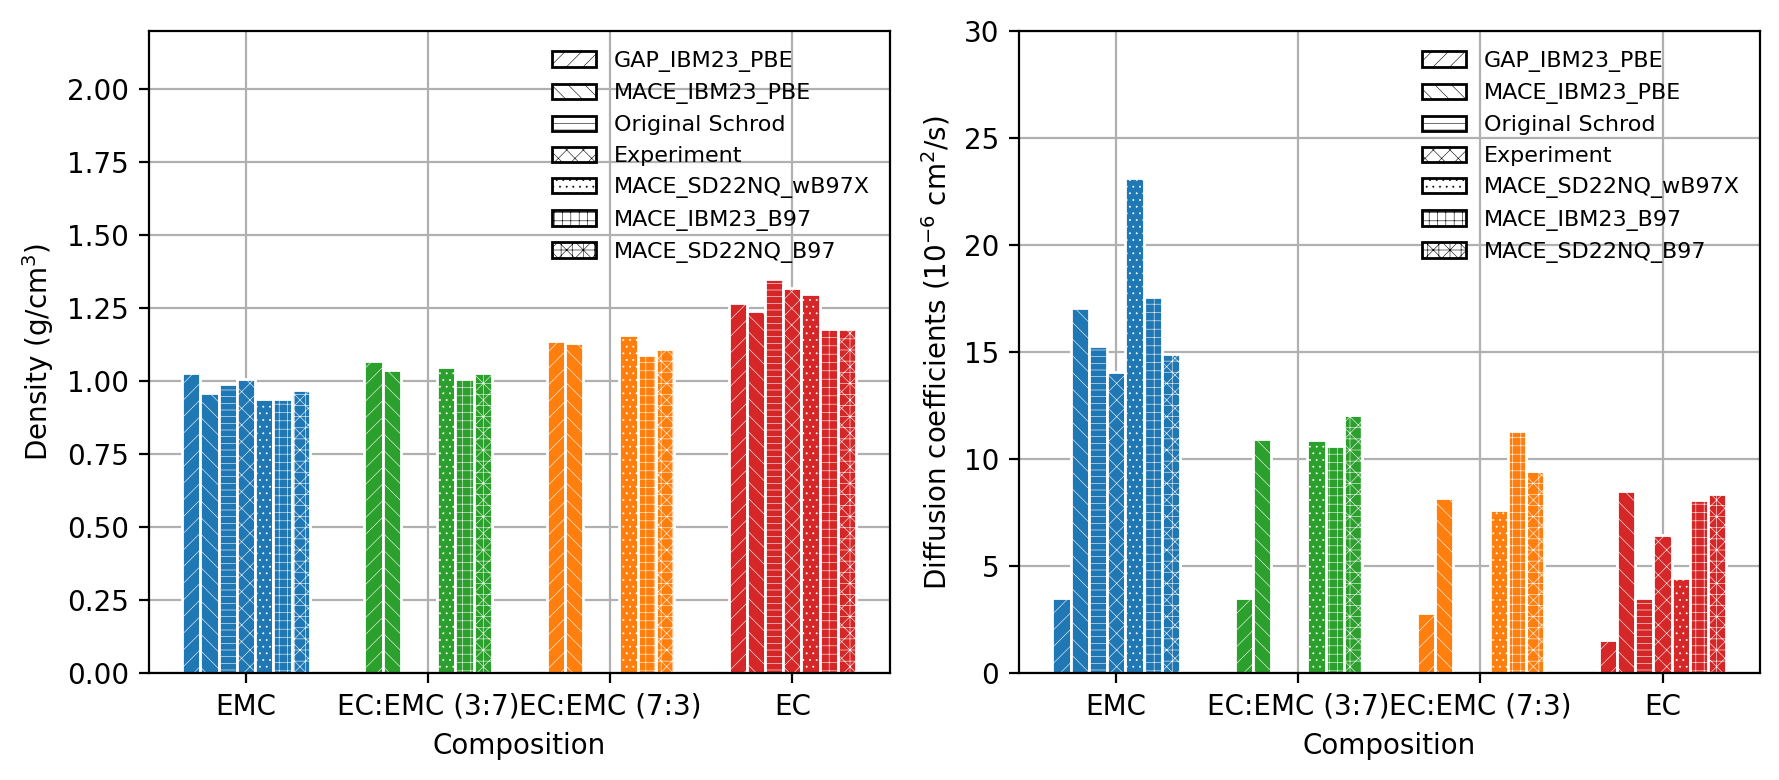

In [31]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.2

def plot_stats(df, prop, ylim, def_htc, w=0.1):
    N = int(df.shape[0]/2)
    for i,(_, dat) in enumerate(df.iterrows()):
        plt.bar(np.arange(4)+(i-N)*w, [val for k, val in dat.items()], width=w, color=def_cols, edgecolor='white', hatch=def_htc[i], fill=True)

    plt.xticks(np.arange(4), dens_df.columns)
    plt.xlabel('Composition')
    plt.ylabel(prop)
    plt.ylim(0, ylim)
    plt.legend(df.index, frameon=False, fontsize=8)
    plt.tight_layout()

    leg = plt.gca().get_legend()
    for h in leg.legend_handles:
        h._hatch_color = (0,0,0,1)
        h._edgecolor = (0,0,0,1)
        h._facecolor = (1,1,1,1)   
    plt.grid()
    plt.gca().set_axisbelow(True)

def_htc = ['////','\\\\\\\\','-----', 'xxxx','.....', '++++', 'x+x+x+x']
plt.figure(figsize=(9,4), dpi=200)
plt.subplot(1,2,1)
plot_stats(dens_df, prop=r'Density (g/cm$^3$)',  ylim=2.2, def_htc=def_htc)
plt.subplot(1,2,2)
plot_stats(diff_df, prop=r'Diffusion coefficients (10$^{-6}$ cm$^2$/s)', ylim=30, def_htc=def_htc)

# To Do Numerical Experiments

## make sure all final comparisons are with MACE
- train MACE on td2@10835267 (CP2K PBE+D3 liquid)
- run MD/300K all compositions with new model

## exclude influence of Dispersion
- run MD/300K all compostions with MACE ml4@10890165 (CASTEP PBE+D2 liquid)

## test hypothesis that diffusivity difference between Schrod in MACE come from lower densities:
- run MD/NVT at Schrodinger density and check if diffusivities match?

## test hypothesis that differences between MACE and Schod come from less data
- train MACE model on full or 50% Schrodinger data neutral
- run MD/300K all compositions with new model

## test hypothesis that clusters do not fully determine diffusivity


# To Do Analysis

## error analysis
- include crude error analysis

## figures
- compile figure illustrating the different Data: Schrodinger and ours

## tables
- define new names for potentials, data, easier to parse
- generate LaTeX tables to include in paper

## exprimental values
- get experimental values from [Wang2022](https://doi.org/10.1016/j.xcrp.2022.101047)